In [1]:
# https://www.kaggle.com/haqishen/train-efficientnet-b0-w-36-tiles-256-lb0-87
# ORG qwk, 30 epochs: 0.86788
# qwk: 0.85429 ( best for 10 epochs) lr = 3e-4


In [2]:
import os
import sys

In [3]:
import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import math
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm_notebook as tqdm
import gc

In [4]:
DEBUG=True
data_dir = '../data'
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
image_folder = os.path.join(data_dir, 'train_images')

kernel_type = 'effnet_b3_script4d'

enet_type = 'efficientnet-b3'
fold = 0
tile_size = 256
image_size = 256
n_tiles = 16
batch_size = 2
num_workers = 4
out_dim = 5
init_lr = 3e-4
warmup_factor = 10

warmup_epo = 5
n_epochs = 10 if DEBUG else 30
# df_train = df_train.sample(100).reset_index(drop=True) if DEBUG else df_train

device = torch.device('cuda')

print(image_folder)

../data/train_images


In [5]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['isup_grade'])):
    df_train.loc[valid_idx, 'fold'] = i
df_train.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,1
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,4
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,1
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,1
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,2


In [6]:
df_train.isup_grade.nunique()

6

In [7]:
df_train.isup_grade.value_counts()

0    2892
1    2666
2    1343
4    1249
3    1242
5    1224
Name: isup_grade, dtype: int64

In [8]:
# https://github.com/ai-med/squeeze_and_excitation/blob/master/squeeze_and_excitation/squeeze_and_excitation.py
"""
Squeeze and Excitation Module
*****************************
Collection of squeeze and excitation classes where each can be inserted as a block into a neural network architechture
    1. `Channel Squeeze and Excitation <https://arxiv.org/abs/1709.01507>`_
    2. `Spatial Squeeze and Excitation <https://arxiv.org/abs/1803.02579>`_
    3. `Channel and Spatial Squeeze and Excitation <https://arxiv.org/abs/1803.02579>`_
"""

from enum import Enum

import torch
import torch.nn as nn
import torch.nn.functional as F


class ChannelSELayer(nn.Module):
    """
    Re-implementation of Squeeze-and-Excitation (SE) block described in:
        *Hu et al., Squeeze-and-Excitation Networks, arXiv:1709.01507*
    """

    def __init__(self, num_channels, reduction_ratio=2):
        """
        :param num_channels: No of input channels
        :param reduction_ratio: By how much should the num_channels should be reduced
        """
        super(ChannelSELayer, self).__init__()
        num_channels_reduced = num_channels // reduction_ratio
        self.reduction_ratio = reduction_ratio
        self.fc1 = nn.Linear(num_channels, num_channels_reduced, bias=True)
        self.fc2 = nn.Linear(num_channels_reduced, num_channels, bias=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_tensor):
        """
        :param input_tensor: X, shape = (batch_size, num_channels, H, W)
        :return: output tensor
        """
        batch_size, num_channels, H, W = input_tensor.size()
        # Average along each channel
        squeeze_tensor = input_tensor.view(batch_size, num_channels, -1).mean(dim=2)

        # channel excitation
        fc_out_1 = self.relu(self.fc1(squeeze_tensor))
        fc_out_2 = self.sigmoid(self.fc2(fc_out_1))

        a, b = squeeze_tensor.size()
        output_tensor = torch.mul(input_tensor, fc_out_2.view(a, b, 1, 1))
        return output_tensor

In [9]:
class SpatialSELayer(nn.Module):
    """
    Re-implementation of SE block -- squeezing spatially and exciting channel-wise described in:
        *Roy et al., Concurrent Spatial and Channel Squeeze & Excitation in Fully Convolutional Networks, MICCAI 2018*
    """

    def __init__(self, num_channels):
        """
        :param num_channels: No of input channels
        """
        super(SpatialSELayer, self).__init__()
        self.conv = nn.Conv2d(num_channels, 1, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor, weights=None):
        """
        :param weights: weights for few shot learning
        :param input_tensor: X, shape = (batch_size, num_channels, H, W)
        :return: output_tensor
        """
        # spatial squeeze
        batch_size, channel, a, b = input_tensor.size()

        if weights is not None:
            weights = torch.mean(weights, dim=0)
            weights = weights.view(1, channel, 1, 1)
            out = F.conv2d(input_tensor, weights)
        else:
            out = self.conv(input_tensor)
        squeeze_tensor = self.sigmoid(out)

        # spatial excitation
        # print(input_tensor.size(), squeeze_tensor.size())
        squeeze_tensor = squeeze_tensor.view(batch_size, 1, a, b)
        output_tensor = torch.mul(input_tensor, squeeze_tensor)
        #output_tensor = torch.mul(input_tensor, squeeze_tensor)
        return output_tensor

class ChannelSpatialSELayer(nn.Module):
    """
    Re-implementation of concurrent spatial and channel squeeze & excitation:
        *Roy et al., Concurrent Spatial and Channel Squeeze & Excitation in Fully Convolutional Networks, MICCAI 2018, arXiv:1803.02579*
    """

    def __init__(self, num_channels, reduction_ratio=2):
        """
        :param num_channels: No of input channels
        :param reduction_ratio: By how much should the num_channels should be reduced
        """
        super(ChannelSpatialSELayer, self).__init__()
        self.cSE = ChannelSELayer(num_channels, reduction_ratio)
        self.sSE = SpatialSELayer(num_channels)

    def forward(self, input_tensor):
        """
        :param input_tensor: X, shape = (batch_size, num_channels, H, W)
        :return: output_tensor
        """
        output_tensor = torch.max(self.cSE(input_tensor), self.sSE(input_tensor))
        return output_tensor


class SELayer(Enum):
    """
    Enum restricting the type of SE Blockes available. So that type checking can be adding when adding these blockes to
    a neural network::
        if self.se_block_type == se.SELayer.CSE.value:
            self.SELayer = se.ChannelSpatialSELayer(params['num_filters'])
        elif self.se_block_type == se.SELayer.SSE.value:
            self.SELayer = se.SpatialSELayer(params['num_filters'])
        elif self.se_block_type == se.SELayer.CSSE.value:
            self.SELayer = se.ChannelSpatialSELayer(params['num_filters'])
    """
    NONE = 'NONE'
    CSE = 'CSE'
    SSE = 'SSE'
    CSSE = 'CSSE'

In [10]:
# import pretrainedmodels
# model_name='se_resnext50_32x4d'

In [11]:
# base_model

In [12]:
# batch_size = 2
# x = torch.randn(batch_size, 3, 512, 512)

In [13]:
# z = base_model(x)

In [14]:
# z.shape

In [15]:
# enc = nn.Sequential(*list(base_model.children())[:-2])    

In [16]:
# z = enc(x)
# z.shape

In [17]:
# del base_model

In [18]:
# # backbone_model = enet.EfficientNet.from_name('efficientnet-b0')
# # backbone_layers = torch.nn.ModuleList(backbone_model.children())[:-5]
# # features = torch.nn.Sequential(*backbone_layers)
# class seresnext50v2(nn.Module):
#     def __init__(self, backbone, out_dim):
#         super(seresnext50v2, self).__init__()
#         self.base_model = pretrainedmodels.__dict__[backbone](pretrained='imagenet')
#         self.enc = nn.Sequential(*list(self.base_model.children())[:-1])    
# #         self.enet.load_state_dict(torch.load(pretrained_model[backbone]))
# #         self.backbone_layers = torch.nn.ModuleList(self.enet.children())[:-5]
# #         self.features = nn.Sequential(*self.backbone_layers)
# #         self.features = nn.Sequential(*list(self.enet.children())[:-5])
# #         self.base_model.avg_pool = nn.Identity()
# #         self.base_model.last_linear = nn.Identity()
# #         self.sse = SpatialSELayer(2048)
#         self.conv = nn.Conv2d(2048, 64, 1)
#         self.flatten = nn.Flatten()
# #         nc = self.flatten.shape[0] * self.flatten.shape[1]
#         self.mymodel = nn.Sequential(
#             nn.Linear(64 * 34 * 34,1024),
#             nn.ReLU(True),
#             nn.Dropout(p=0.5),
#             nn.Linear(1024, out_dim))
# #         self.sSE = SpatialSELayer(1024)
# # #         self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
# #         self.myfc1 = nn.Linear(1024, 512)
# # #         self.relu1 = nn.ReLU()
# #         self.dropout = nn.Dropout(0.5)
# #         self.myfc = nn.Linear(1024, out_dim)
# #         self.enet._fc = nn.Identity()

#     def extract(self, x):
#         return self.enc(x)
# #         return self.features(x)

#     def forward(self, x):
#         x = self.enc(x)
# #         print(x.shape)
# #         x = self.sse(x)
#         x = self.conv(x)
# #         print(x.shape)
#         x = self.flatten(x)
# #         print(x.shape)
# #         x = x.view(1, -1)
# #         print(x.shape)
#         x = self.mymodel(x)
#         return x

In [19]:
# model = seresnext50v2(model_name, out_dim)

In [20]:
# z = model(x)

In [21]:
# z.shape

In [22]:
# del model
# gc.collect()

In [23]:
pretrained_model = {
    'efficientnet-b3': '/home/watts/.torch/models/efficientnet-b3-c8376fa2.pth'
}

In [24]:
# backbone_model = enet.EfficientNet.from_name('efficientnet-b0')
# backbone_layers = torch.nn.ModuleList(backbone_model.children())[:-5]
# # features = torch.nn.Sequential(*backbone_layers)
# meta = torch.nn.Sequential(*backbone_layers, SpatialSELayer(1024),
#                                   nn.Linear(1024, 512),
#                                   nn.ReLU(),
#                                   nn.Dropout(p=0.2),
#                                   nn.Linear(512, out_dim))

In [25]:
# meta

In [26]:
# backbone_model

In [27]:
# features

In [28]:
sigmoid = torch.nn.Sigmoid()
class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))

swish = Swish.apply

class Swish_module(nn.Module):
    def forward(self, x):
        return swish(x)

swish_layer = Swish_module()

def relu_fn(x):
    """ Swish activation function """
    return swish_layer(x)


In [29]:
class DenseCrossEntropy(nn.Module):
    def forward(self, x, target, reduction='mean'):
        x = x.float()
        target = target.float()
        logprobs = torch.nn.functional.log_softmax(x, dim=-1)

        loss = -logprobs * target
        loss = loss.sum(-1)
        if reduction == 'mean':
            return loss.mean()
        elif reduction == 'sum':
            return loss.sum()
        elif reduction == 'none':
            return loss

In [30]:
class ArcFaceLoss(nn.modules.Module):
    def __init__(self, s=30.0, m=0.5, reduction='mean'):
        super().__init__()
        self.reduction = reduction
        self.s = s
        self.cos_m = math.cos(m)             #  0.87758
        self.sin_m = math.sin(m)             #  0.47943
        self.th = math.cos(math.pi - m)      # -0.87758
        self.mm = math.sin(math.pi - m) * m  #  0.23971

    def forward(self, logits, labels):
        logits = logits.float()  # float16 to float32 (if used float16)
        cosine = logits
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))  # equals to **2
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        output = (labels * phi) + ((1.0 - labels) * cosine)
        output *= self.s
        loss = DenseCrossEntropy()(output, labels, self.reduction)
        return loss / 2


In [31]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, features):
        cosine = F.linear(F.normalize(features), F.normalize(self.weight))
        return cosine


In [32]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(pretrained_model[backbone]))

        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [33]:
# class enetv2(nn.Module):

#     def __init__(self, backbone, out_dim):
#         super(enetv2, self).__init__()
#         self.enet = enet.EfficientNet.from_name(backbone)
#         self.enet.load_state_dict(torch.load(pretrained_model[backbone]), strict=True)
#         self.dropouts = nn.ModuleList([
#             nn.Dropout(0.5) for _ in range(5)
#         ])

#         self.gfc = nn.Linear(self.enet._fc.in_features, 4096)
#         self.metric_classify = ArcMarginProduct(4096, out_dim)
#         self.myfc_1 = nn.Linear(4096, out_dim)
# #         self.myfc_2_1 = nn.Linear(4096, 512)
# #         self.myfc_2_2 = nn.Linear(512, out_dim_2)
#         self.enet._fc = nn.Identity()

#     def extract(self, x):
#         return self.enet(x)

#     def forward(self, x):
#         x = self.extract(x)
#         x = Swish_module()(self.gfc(x))
#         for i, dropout in enumerate(self.dropouts):
#             if i == 0:
#                 out_1 = self.myfc_1(dropout(x))
                
#             else:
#                 out_1 += self.myfc_1(dropout(x))
#         out_1 /= len(self.dropouts)
#         metric_output = self.metric_classify(x)
#         return out_1, metric_output

In [34]:
# backbone_model = enet.EfficientNet.from_name('efficientnet-b0')
# backbone_layers = torch.nn.ModuleList(backbone_model.children())[:-5]
# features = torch.nn.Sequential(*backbone_layers)
# class enetv2(nn.Module):
#     def __init__(self, backbone, out_dim):
#         super(enetv2, self).__init__()
#         self.enet = enet.EfficientNet.from_name(backbone)
#         self.enet.load_state_dict(torch.load(pretrained_model[backbone]))
# #         self.backbone_layers = torch.nn.ModuleList(self.enet.children())[:-5]
# #         self.features = nn.Sequential(*self.backbone_layers)
# #         self.features = nn.Sequential(*list(self.enet.children())[:-5])
#         self.enet._fc = nn.Identity()
#         self.enet._dropout = nn.Identity()
#         self.enet._avg_pooling = nn.Identity()
#         self.enet._bn1 = nn.Identity()
#         self.enet._conv_head = nn.Identity()
#         self.mymodel = nn.Sequential(
#             SpatialSELayer(1280),
#             nn.Linear(1280, 512),
#             nn.ReLU(True),
#             nn.Dropout(p=0.2),
#             nn.Linear(512, out_dim))
# #         self.sSE = SpatialSELayer(1024)
# # #         self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
# #         self.myfc1 = nn.Linear(1024, 512)
# # #         self.relu1 = nn.ReLU()
# #         self.dropout = nn.Dropout(0.5)
# #         self.myfc = nn.Linear(1024, out_dim)
# #         self.enet._fc = nn.Identity()

#     def extract(self, x):
#         return self.enet(x)
# #         return self.features(x)

#     def forward(self, x):
#         x = self.enet(x)
#         print(x.shape)
#         x = self.mymodel(x)
#         return x

In [35]:
def get_tiles(img, mode=0):
        result = []
        h, w, c = img.shape
        pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
        pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)

        img2 = np.pad(img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values=255)
        img3 = img2.reshape(
            img2.shape[0] // tile_size,
            tile_size,
            img2.shape[1] // tile_size,
            tile_size,
            3
        )

        img3 = img3.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        n_tiles_with_info = (img3.reshape(img3.shape[0],-1).sum(1) < tile_size ** 2 * 3 * 255).sum()
        if len(img3) < n_tiles:
            img3 = np.pad(img3,[[0,n_tiles-len(img3)],[0,0],[0,0],[0,0]], constant_values=255)
        idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:n_tiles]
        img3 = img3[idxs]
        for i in range(len(img3)):
            result.append({'img':img3[i], 'idx':i})
        return result, n_tiles_with_info >= n_tiles


In [36]:
class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=n_tiles,
                 tile_mode=0,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        tiff_file = os.path.join(image_folder, f'{img_id}.tiff')
#         print(tiff_file)
        image = skimage.io.MultiImage(tiff_file)[1]
        tiles, OK = get_tiles(image, self.tile_mode)

        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))
            
        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
    
                if len(tiles) > idxes[i]:
                    this_img = tiles[idxes[i]]['img']
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img

        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)

        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(images), torch.tensor(label)

In [37]:
transforms_train = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])
transforms_val = albumentations.Compose([])

In [38]:
# tiff_file = "../data/train_images/984505f6a79b889bed5897d2135b85b1.tiff"
# image = skimage.io.MultiImage(tiff_file)[1]

In [39]:
# image[-1]

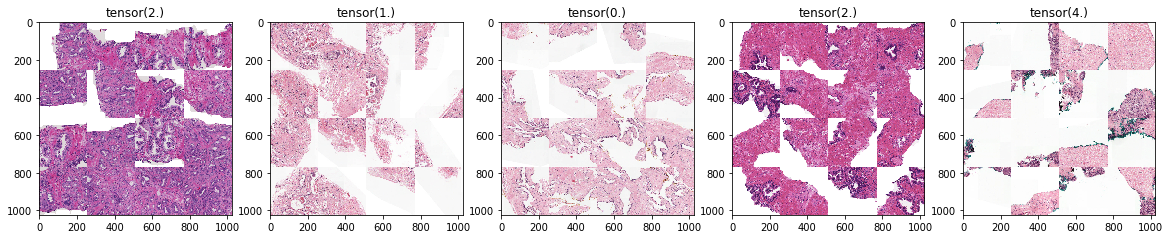

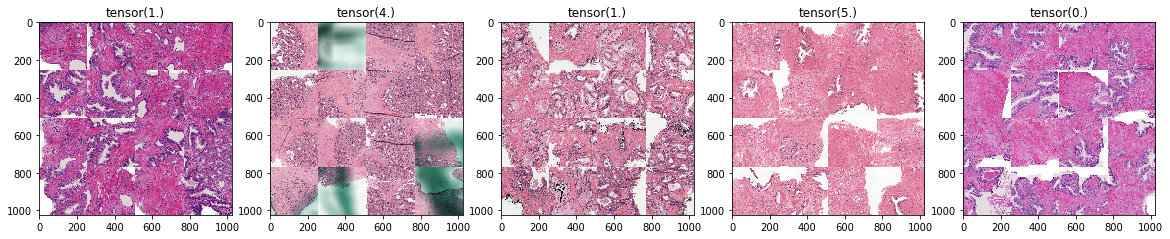

In [40]:
dataset_show = PANDADataset(df_train, image_size, n_tiles, 0, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(sum(label)))

In [41]:
# criterion = nn.BCEWithLogitsLoss()

In [42]:
# loss_weight = [4, 2, 1, 1, 2]
loss_weight = [4, 2]
# c0_dim = 1295

In [43]:
def criterion(logits_1, metric_logits, target, loss_weight=loss_weight, is_val=False):

#     loss_1 = nn.CrossEntropyLoss()(logits_2[:, :c1_dim], target[:, 1]) * loss_weight[1]
#     loss_2 = nn.CrossEntropyLoss()(logits_2[:, c1_dim:c1_dim+c2_dim], target[:, 2]) * loss_weight[2]
#     loss_3 = nn.CrossEntropyLoss()(logits_2[:, c1_dim+c2_dim:], target[:, 3]) * loss_weight[3]

#     if is_val:
#         loss = (loss_1 + loss_2 + loss_3) / sum(loss_weight[1:4])
#     else:
    

#     loss_0 = nn.BCEWithLogitsLoss()(logits_1, target) * loss_weight[0]
#     loss_metric = ArcFaceLoss()(metric_logits, target.float()) * loss_weight[1]
#     loss = (loss_0 + loss_metric) / sum(loss_weight)
    loss = nn.BCEWithLogitsLoss()(logits_1, target)
#     loss = nn.CrossEntropyLoss()(logits_1, target)
    return loss

In [44]:
def train_epoch(loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
#         print(data.shape, target.shape)
        logits = model(data)
        loss = loss_func(logits, logits, target)
        loss.backward()
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss

In [45]:
def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, logits, target)

            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
    qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
    qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
    print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk

In [46]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

dataset_train = PANDADataset(df_this , image_size, n_tiles, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=num_workers)

model = enetv2(enet_type, out_dim=out_dim)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

print(len(dataset_train), len(dataset_valid))

8490 2126


In [47]:
qwk_max = 0.
best_file = f'../cache/{kernel_type}_best_fold{fold}.pth'
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler.step(epoch-1)

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, qwk = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
    print(content)
    with open(f'log_{kernel_type}.txt', 'a') as appender:
        appender.write(content + '\n')

    if qwk > qwk_max:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
        torch.save(model.state_dict(), best_file)
        qwk_max = qwk

torch.save(model.state_dict(), os.path.join(f'../cache/{kernel_type}_final_fold{fold}.pth'))

Tue Jun 30 06:37:39 2020 Epoch: 1


/home/watts/anaconda3/envs/panda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



qwk 0.7305782539643354 qwk_k 0.6851337483472502 qwk_r 0.67931761469076
Tue Jun 30 07:15:56 2020 Epoch 1, lr: 0.0000300, train loss: 0.46699, val loss: 0.33361, acc: 33.77234, qwk: 0.73058
score2 (0.000000 --> 0.730578).  Saving model ...
Tue Jun 30 07:15:56 2020 Epoch: 2



qwk 0.7944906681367632 qwk_k 0.7586986633439811 qwk_r 0.7614779001012708
Tue Jun 30 07:54:44 2020 Epoch 2, lr: 0.0000840, train loss: 0.36164, val loss: 0.29564, acc: 55.03293, qwk: 0.79449
score2 (0.730578 --> 0.794491).  Saving model ...
Tue Jun 30 07:54:44 2020 Epoch: 3



qwk 0.7827622677367572 qwk_k 0.7449009598164976 qwk_r 0.7385308056371023
Tue Jun 30 08:33:35 2020 Epoch 3, lr: 0.0001380, train loss: 0.31932, val loss: 0.30734, acc: 44.44967, qwk: 0.78276
Tue Jun 30 08:33:35 2020 Epoch: 4



qwk 0.7960067605736387 qwk_k 0.7979358695786914 qwk_r 0.7293967561072527
Tue Jun 30 09:12:25 2020 Epoch 4, lr: 0.0001920, train loss: 0.30245, val loss: 0.36759, acc: 43.93227, qwk: 0.79601
score2 (0.794491 --> 0.796007).  Saving model ...
Tue Jun 30 09:12:25 2020 Epoch: 5



qwk 0.8250187590555188 qwk_k 0.8365433118522043 qwk_r 0.7761360414958741
Tue Jun 30 09:51:19 2020 Epoch 5, lr: 0.0002460, train loss: 0.29412, val loss: 0.27278, acc: 60.48918, qwk: 0.82502
score2 (0.796007 --> 0.825019).  Saving model ...
Tue Jun 30 09:51:19 2020 Epoch: 6



qwk 0.8127389602589393 qwk_k 0.8268467262844355 qwk_r 0.7478174326785101
Tue Jun 30 10:30:10 2020 Epoch 6, lr: 0.0003000, train loss: 0.28878, val loss: 0.31707, acc: 50.61148, qwk: 0.81274
Tue Jun 30 10:30:10 2020 Epoch: 7



qwk 0.8413346663635833 qwk_k 0.8535596847445913 qwk_r 0.7919225183999552
Tue Jun 30 11:09:05 2020 Epoch 7, lr: 0.0000300, train loss: 0.23557, val loss: 0.25654, acc: 59.03104, qwk: 0.84133
score2 (0.825019 --> 0.841335).  Saving model ...
Tue Jun 30 11:09:05 2020 Epoch: 8



qwk 0.8226013118853189 qwk_k 0.8372766755359973 qwk_r 0.7685912854229395
Tue Jun 30 11:47:57 2020 Epoch 8, lr: 0.0001964, train loss: 0.25192, val loss: 0.28187, acc: 56.53810, qwk: 0.82260
Tue Jun 30 11:47:57 2020 Epoch: 9



qwk 0.8437527761975325 qwk_k 0.855432439906358 qwk_r 0.7956819902520944
Tue Jun 30 12:26:52 2020 Epoch 9, lr: 0.0001036, train loss: 0.22300, val loss: 0.25011, acc: 61.90028, qwk: 0.84375
score2 (0.841335 --> 0.843753).  Saving model ...
Tue Jun 30 12:26:52 2020 Epoch: 10



qwk 0.8542915737729422 qwk_k 0.8644786490296308 qwk_r 0.8081986172073593
Tue Jun 30 13:05:46 2020 Epoch 10, lr: 0.0000286, train loss: 0.19683, val loss: 0.25053, acc: 60.39511, qwk: 0.85429
score2 (0.843753 --> 0.854292).  Saving model ...
